In [1]:
import pandas as pd
import sqlite3
import requests

In [30]:
def fetch_intraday_data(ticker, interval='1min'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={ticker}&interval={interval}&outputsize=full&apikey=GSJ1V5C26N6UUCJ1'
    response = requests.get(url)
    data = response.json()
    #print(data)

    time_series = data.get(f'Time Series ({interval})', {})
    if not time_series:
        print(f'No data returned for {ticker}')
        return None

    df = pd.DataFrame(time_series).T
    df.index.name = 'timestamp'
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df = df.sort_index()
    df.reset_index(inplace = True)
    df['ticker'] = ticker
    return df

In [31]:
fetch_intraday_data('IBM')

,timestamp,open,high,low,close,volume,ticker
0,2024-09-12 04:00:00,209.9900,210.0000,209.9900,210.0000,130,IBM
1,2024-09-12 04:01:00,210.0000,210.0000,210.0000,210.0000,1,IBM
2,2024-09-12 04:02:00,210.1700,210.1700,209.5700,210.0100,14,IBM
3,2024-09-12 04:04:00,210.0000,210.0000,209.6100,209.6100,2,IBM
4,2024-09-12 04:07:00,209.8000,209.8000,209.6100,209.6100,9,IBM
...,...,...,...,...,...,...,...
12707,2024-10-11 19:20:00,233.2000,233.2000,233.2000,233.2000,3,IBM
12708,2024-10-11 19:24:00,232.8400,233.0000,232.8000,232.8000,10,IBM
12709,2024-10-11 19:31:00,232.6000,232.6000,232.6000,232.6000,5,IBM
12710,2024-10-11 19:51:00,232.9000,233.1700,232.9000,233.1700,11,IBM


In [55]:
conn = sqlite3.connect('intraday_stock_prices.db')
cursor = conn.cursor()

In [56]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS intraday_prices (
    ticker TEXT,
    timestamp TEXT,
    open REAL,
    high REAL,
    low REAL,
    close REAL,
    volume INTEGER
)
''')

conn.commit()

In [57]:
def get_latest_timestamp(ticker):
    query = """
    SELECT MAX(timestamp) FROM intraday_prices WHERE ticker = ?
    """
    cursor.execute(query, (ticker,))
    result = cursor.fetchone()[0]
    return result

In [58]:
def store_data_to_db(data, latest_timestamp):
    if data is not None:
        if latest_timestamp:
            data = data[data['timestamp'] > latest_timestamp]
        if not data.empty:
            data.to_sql('intraday_prices', conn, if_exists='append', index=False)
            print(f"Data for {data['ticker'].iloc[0]} stored successfully/")
        else: 
            print("No new data to store.")
    else:
        print("No data to store.")

In [59]:
def main():
    tickers = ["MSFT", "IBM"]
    for ticker in tickers:
        latest_timestamp = get_latest_timestamp(ticker)
        data = fetch_intraday_data(ticker)
        store_data_to_db(data, latest_timestamp)

if __name__ == "__main__":
    main()
        

No new data to store.
No new data to store.


In [75]:
def query_data(ticker, start_time, end_time):
    query = f"""SELECT * FROM intraday_prices
    WHERE ticker = '{ticker}'
    AND timestamp BETWEEN '{start_time}' AND '{end_time}'
    order by timestamp desc"""
    df = pd.read_sql(query, conn)
    return df
df = query_data('MSFT','2024-10-09 00:00:00','2024-10-09 19:59:00')

In [76]:
df

,ticker,timestamp,open,high,low,close,volume
0,MSFT,2024-10-09 19:59:00,416.76,417.11,416.5100,416.51,597
1,MSFT,2024-10-09 19:58:00,416.97,416.97,416.7300,416.81,138
2,MSFT,2024-10-09 19:57:00,416.84,416.99,416.7000,416.78,3029
3,MSFT,2024-10-09 19:56:00,416.75,416.99,416.7302,416.99,240
4,MSFT,2024-10-09 19:55:00,416.75,417.08,416.7500,416.92,165
...,...,...,...,...,...,...,...
954,MSFT,2024-10-09 04:04:00,414.85,414.85,414.7800,414.83,117
955,MSFT,2024-10-09 04:03:00,414.85,414.89,414.7400,414.74,160
956,MSFT,2024-10-09 04:02:00,414.71,414.86,414.6200,414.83,303
957,MSFT,2024-10-09 04:01:00,414.86,414.88,414.6000,414.76,621


<Axes: xlabel='timestamp'>

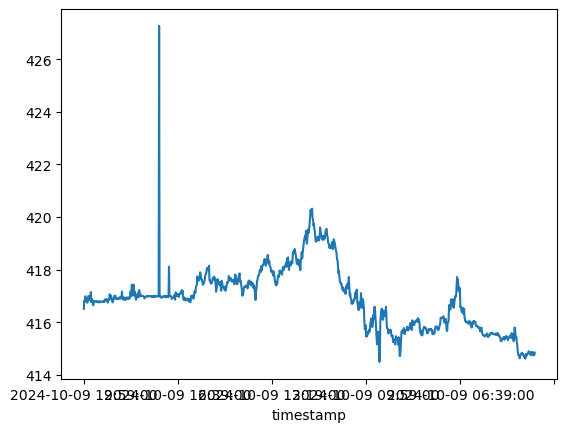

In [77]:
df.set_index('timestamp').close.plot()

In [78]:
conn.close()